# Assignment 1

**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

## Table of contents

1. [Import Libraries](#Import-Libraries)
2. [Get Data](#Get-Data)


## 1. Import Libraries <a name="Import-Libraries"></a>

In [1]:
import warnings
import itertools
import subprocess
import psycopg2

import pandas            as pd
import numpy             as np
import statsmodels.api   as sm
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from datetime   import datetime

%matplotlib inline
plt.style.use('ggplot')

## 2. Get Data <a name="Get-Data"></a>

We have 2 options here toggled by the 'in_school' variable.
If this variable is set to True we will obtain our data by pulling a JSON object from the heroku webserver.
If it is set to False we will obtain it by first connecting to the Heroku PostgreSQL database and applying a simple SQL querry to that database.

In [2]:
in_school = True

if (True == in_school):
    # Get the data from the web route because school blocks the port used by the database :)
    
    url = 'https://pxl-ss.herokuapp.com/api/temps'
    data = pd.read_json(url, orient='columns')
else:
    # Get the data directly from the database
    
    HEROKU_APP_NAME = "pxl-ss"
    TABLE_NAME = "Temperature"

    conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
    connuri = conn_info.stdout.decode('utf-8').strip()

    engine = create_engine(connuri)
    raw_engine = engine.raw_connection()

    data = pd.read_sql_query("SELECT * FROM Temperature;", raw_engine)
    
print(data.head())

                      creation_date  id                          place  value
0  2018-11-10T23:38:44.453789+00:00   1  Lat:51.037460, Long: 5.301590  21.48
1  2018-11-10T23:53:53.134313+00:00   2  Lat:51.037460, Long: 5.301590  19.48
2  2018-11-10T23:53:57.457321+00:00   3  Lat:51.037460, Long: 5.301590  20.60
3  2018-11-10T23:56:10.690055+00:00   4  Lat:51.037460, Long: 5.301590  20.45
4  2018-11-10T23:58:49.577553+00:00   5  Lat:51.037460, Long: 5.301590  20.76


## Restructure the data to form a time series

The data we got from our source is has multiple tables we don't care about, we really only care about the 'creation_date' & 'value' column.<br>
We create a new pandas dataframe with only those 2 columns and rename them to a more human readable names: 'dateTime' & 'temperature'.

Afther renaming the columns we will have to convert them to the right data type. datetime for the 'dateTime' column and float for the 'temperature' column.

Since we are aiming to work with a time series we have to set the 'dateTime' column as the index.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 2 columns):
dateTime       269 non-null object
temperature    269 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 269 entries, 2018-11-10 23:38:44.453789 to 2018-11-13 09:10:00.097626
Data columns (total 1 columns):
temperature    269 non-null float64
dtypes: float64(1)
memory usage: 4.2 KB
None


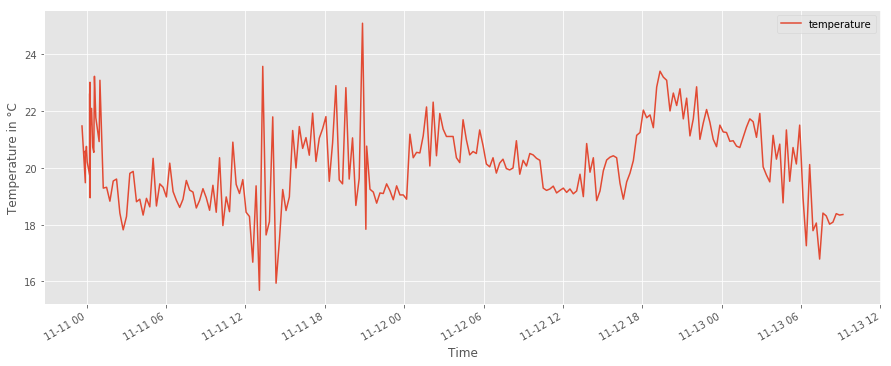

In [3]:
# Filter out all the columsn except for 'creation_date' & 'value'
# Rename those columns to 'dateTime' & temperature
df = pd.DataFrame(data, columns = ['creation_date', 'value'])
df.columns = ['dateTime', 'temperature']

# Inspect data
print(df.info())

# Convert the creation_date column to datetime64
df['dateTime'] = pd.to_datetime(df['dateTime'])
# Convert the value column to float
df['temperature'] = pd.to_numeric(df['temperature'])

# Set the dateTime column as index
df.set_index('dateTime', inplace=True)

# Inspect data
print(df.info())

# Plot data
df.plot(figsize=(15, 6), label='Temperature')
plt.ylabel("Temperature in °C")
plt.xlabel("Time")
plt.show()

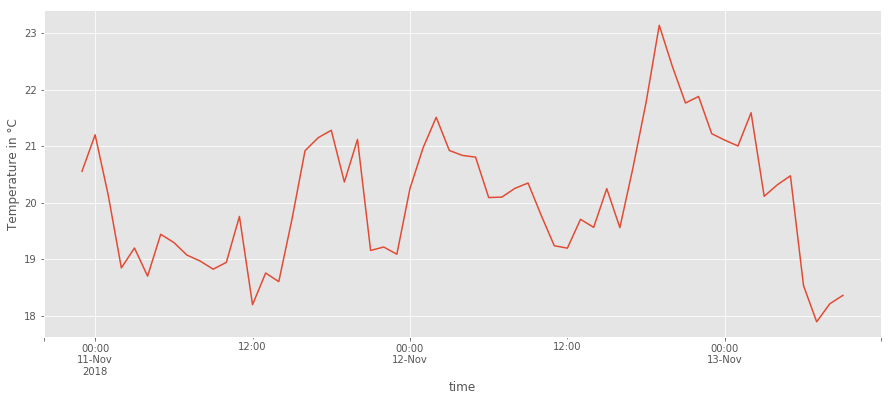

In [4]:
my_df = df['temperature'].resample('60T').mean()
my_df = my_df.fillna(my_df.bfill())

my_df.plot(figsize=(15, 6), label='temperature')
plt.ylabel("Temperature in °C")
plt.xlabel("time")
plt.show()